In [13]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from tqdm import tqdm
import math
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataSet_path='/content/drive/MyDrive/CVPR/Animals'

Find Categories

In [7]:
categories=[]
for i in os.listdir(dataSet_path):
  categories.append(i)
print(categories)

['Tiger', 'Cheetah', 'Jaguar', 'Lion', 'Leopard']


In [12]:
test_dataSet = []
for label, category in enumerate(categories):
    path = os.path.join(dataSet_path, category)
    for img in tqdm(os.listdir(path), desc=f"Processing {category}"):
        img_path = os.path.join(path, img)
        try:

            image_arr = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if image_arr is not None:
                image_arr = cv.resize(image_arr, (256, 256), interpolation=cv.INTER_AREA)
                test_dataSet.append([image_arr, label])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

print(f"\nTotal images processed: {len(test_dataSet)}")

Processing Leopard: 100%|██████████| 31/31 [00:00<00:00, 61.00it/s]


Total images processed: 170


In [15]:
random.shuffle(test_dataSet)

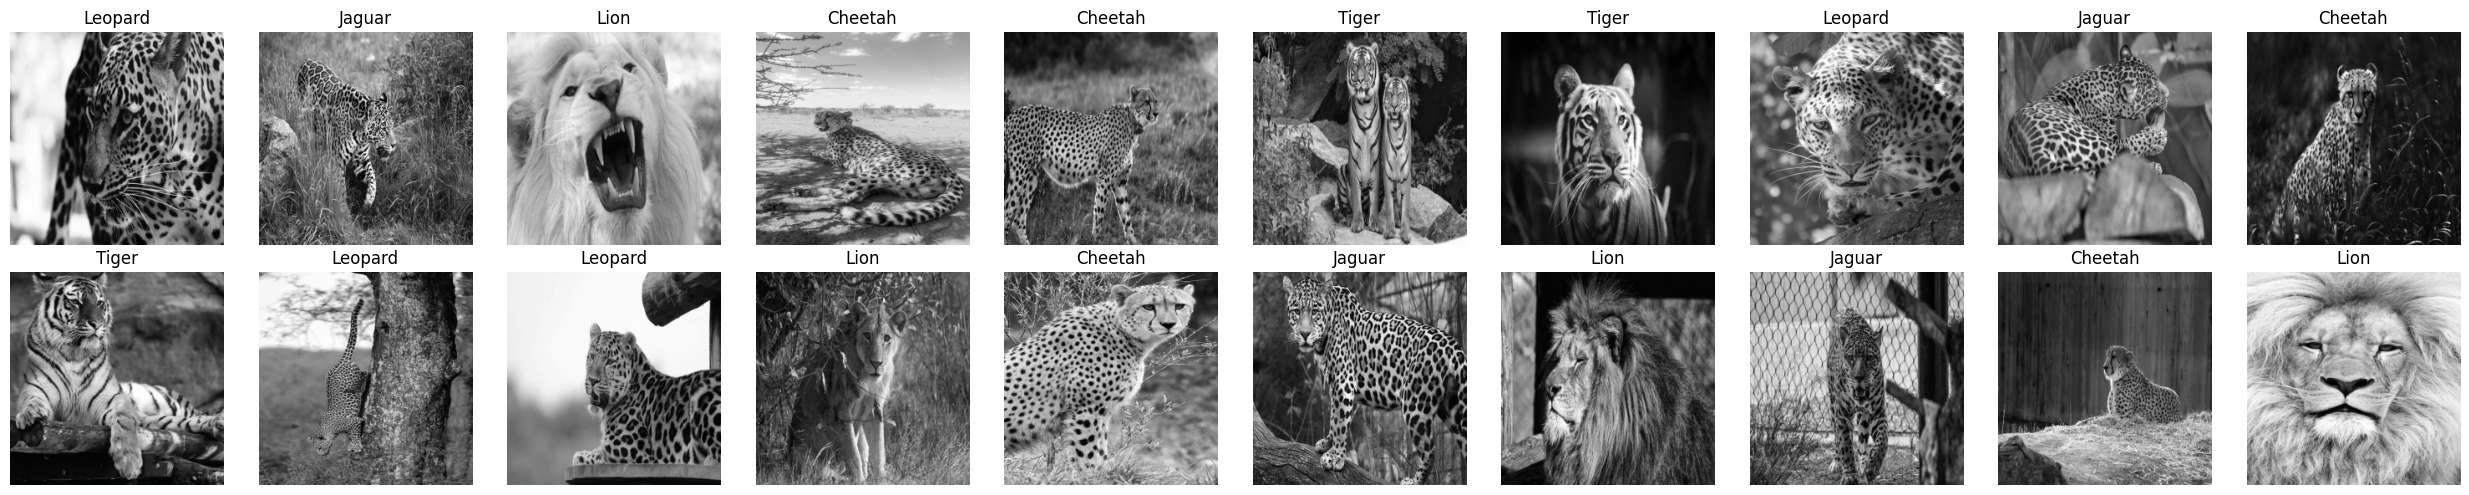

In [16]:
plt.figure(figsize=(25,5))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.imshow(test_dataSet[i][0],cmap='gray')
  plt.title(categories[test_dataSet[i][1]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
def euclidean_d(d1, d2):
    return np.sqrt(np.sum((d1 - d2)**2))



In [30]:
def knn(train_data, k_values):
    k_accuracies = []  # To store accuracies for different k values

    for k in tqdm(k_values):
        folds = np.array_split(train_data, 5)  # Split data into 5 folds

        fold_accuracies = []  # To store accuracy for each fold

        # Cross-validation
        for i in range(5):
            # Use the i-th fold as the validation set
            validation_set = folds[i]

            # Use the remaining folds as the training set
            training_set = np.concatenate([folds[j] for j in range(5) if j != i])

            correct_predictions = 0

            for v in validation_set:
                distances = []
                for t in training_set:
                    d = euclidean_d(t[0], v[0])  # Calculate Euclidean distance
                    distances.append([d, t[1]])  # Store distance and label

                distances.sort()  # Sort by distance

                # Extract labels of k nearest neighbors
                k_nearest_labels = [distances[j][1] for j in range(k)]

                # Determine the most common label
                label_counts = Counter(k_nearest_labels)
                most_common_label = max(label_counts, key=label_counts.get)

                # Check if the prediction matches the true label
                if most_common_label == v[1]:
                    correct_predictions += 1

            # Calculate accuracy for this fold
            fold_accuracy = correct_predictions / len(validation_set)
            fold_accuracies.append(fold_accuracy)

        # Store accuracies for this k
        k_accuracies.append((k, fold_accuracies))

    return k_accuracies


In [32]:
# Ensure consistent variable naming
train_dataSet = np.array(test_dataSet, dtype=object)
k_values = range(1, 31)

# Call the knn function
euclidean_accuracies = knn(train_dataSet, k_values)

# Iterate through the returned accuracies
for k, fold_accuracies in euclidean_accuracies:
    for accuracy in fold_accuracies:
        print(f'k = {k}, accuracy = {accuracy:.6f}')


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

k = 1, accuracy = 0.235294
k = 1, accuracy = 0.323529
k = 1, accuracy = 0.411765
k = 1, accuracy = 0.323529
k = 1, accuracy = 0.294118
k = 2, accuracy = 0.235294
k = 2, accuracy = 0.323529
k = 2, accuracy = 0.411765
k = 2, accuracy = 0.323529
k = 2, accuracy = 0.294118
k = 3, accuracy = 0.176471
k = 3, accuracy = 0.323529
k = 3, accuracy = 0.352941
k = 3, accuracy = 0.294118
k = 3, accuracy = 0.323529
k = 4, accuracy = 0.205882
k = 4, accuracy = 0.294118
k = 4, accuracy = 0.323529
k = 4, accuracy = 0.176471
k = 4, accuracy = 0.323529
k = 5, accuracy = 0.235294
k = 5, accuracy = 0.294118
k = 5, accuracy = 0.352941
k = 5, accuracy = 0.264706
k = 5, accuracy = 0.411765
k = 6, accuracy = 0.235294
k = 6, accuracy = 0.205882
k = 6, accuracy = 0.411765
k = 6, accuracy = 0.235294
k = 6, accuracy = 0.411765
k = 7, accuracy = 0.205882
k = 7, accuracy = 0.235294
k = 7, accuracy = 0.382353
k = 7, accuracy = 0.176471
k = 7, accuracy = 0.411765
k = 8, accuracy = 0.176471
k = 8, accuracy = 0.264706
k

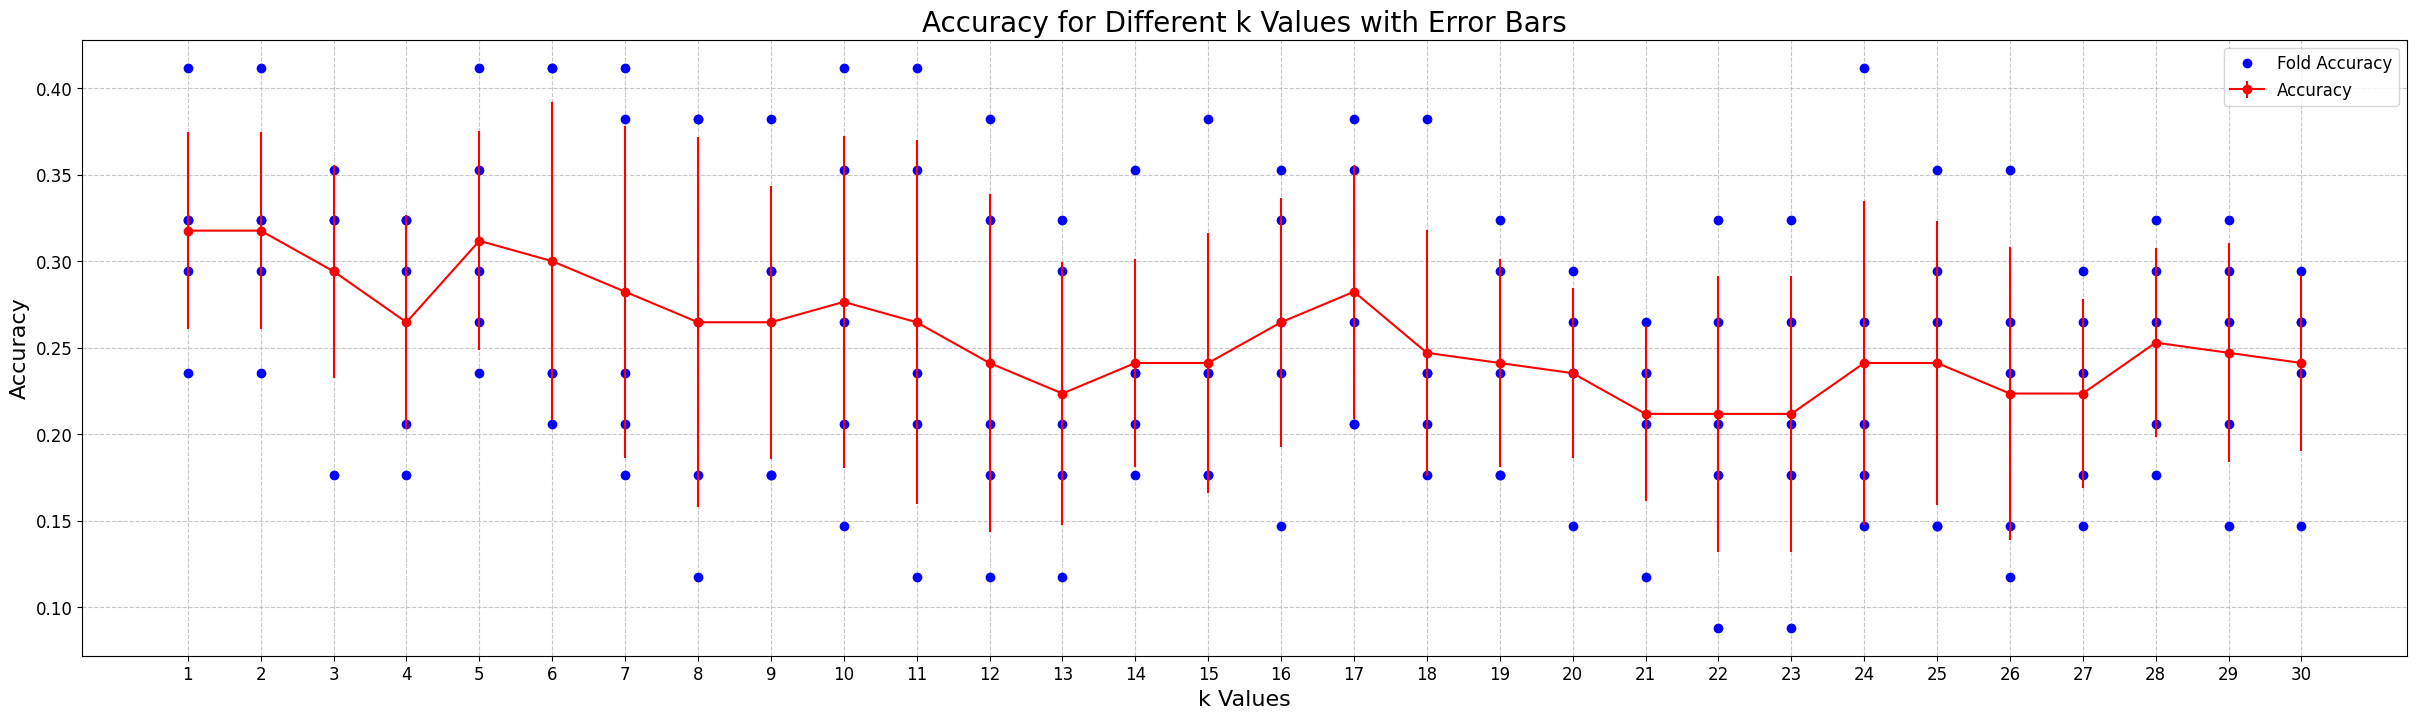

In [35]:
plt.figure(figsize=(30, 8))

# Plot fold accuracies for each k value
for k, fold_accuracies in euclidean_accuracies:
    plt.plot([k] * len(fold_accuracies), fold_accuracies, 'bo', label='Fold Accuracy' if k == 1 else "")  # Plot points

# Compute mean and standard deviation for each k value
euclidean_mean_accuracies = []
euclidean_std_accuracies = []

for k, fold_accuracies in euclidean_accuracies:
    mean_acc = np.mean(fold_accuracies)  # Compute mean
    std_acc = np.std(fold_accuracies)   # Compute standard deviation

    euclidean_mean_accuracies.append(mean_acc)
    euclidean_std_accuracies.append(std_acc)

# Plot error bars for the mean accuracies
plt.errorbar(k_values, euclidean_mean_accuracies, yerr=euclidean_std_accuracies, fmt='-o', label='Accuracy', color='r')

# Add title and labels
plt.title('Accuracy for Different k Values with Error Bars', fontsize=20)
plt.xlabel('k Values', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

# Customize x-axis ticks
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Display the plot
plt.show()
